<a href="https://colab.research.google.com/github/MarcelusGlaucus/QGIS-Documentation/blob/master/Busca_Topo_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.signal import savgol_filter
from scipy.stats import zscore
from scipy.stats.mstats import pearsonr
import os

In [ ]:
!g++ psi_UCR_suite.cpp -o ucr.run
def getLocation(sism, sint, n, w):
  command_init = "./ucr.run "
  command_end = " > saida.txt"
  command = command_init+sism+" "+sint+" "+str(n)+" "+str(w)+command_end
  print(command)
  os.system(command)

  arq = open("saida.txt", "r")
  loc = int(arq.read())

  return loc

In [ ]:
df = pd.read_csv("ELPS_14B_sint_sism.csv", delimiter=';', thousands=',')

df.head()

Poço  Profundidade  (A) INTERCEPT_ORIG_TEMPO  (B) PSTM_COR
0  1-ELPS-14B-SPS     27.750000              6.800000e-09    -47.673950
1  1-ELPS-14B-SPS     29.250000             -6.800000e-09     51.321182
2  1-ELPS-14B-SPS     30.750000             -1.920000e-08    150.316315
3  1-ELPS-14B-SPS     32.250000             -2.850000e-08    265.228104
4  1-ELPS-14B-SPS     33.750001             -3.360000e-08    380.139893

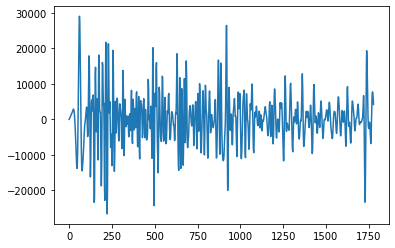

In [ ]:
plt.plot(df['(B) PSTM_COR'])

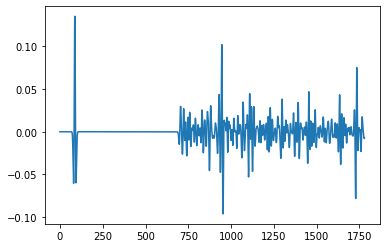

In [ ]:
plt.plot(df['(A) INTERCEPT_ORIG_TEMPO'])

In [ ]:
def dtw(x, y, w=0.05):
    
    x = zscore(x)
    y = zscore(y)

    lx = len(x)
    ly = len(y)
    r = int(np.ceil(ly * w))

    dm = np.full((lx+1,ly+1), np.inf)
    dm[0][0] = 0

    for i in range(1,lx+1):
        beg_j = np.max([1, i-r])
        end_j = np.min([i+r+1, ly+1])
        for j in range(beg_j,end_j):
            dm[i][j] = np.square(x[i-1] - y[j-1]) + np.min([dm[i-1][j], dm[i][j-1], dm[i-1][j-1]])

    
    i = lx
    j = ly
    pairs = [[lx-1,ly-1]]
    while (i > 0 or j > 0):
        if (dm[i-1][j] < dm[i][j-1]):
            i -= 1
            if (dm[i-1][j] > dm[i-1][j-1]):
                j -= 1
        elif (dm[i][j-1] < dm[i-1][j-1]):
            j -= 1
        else:
            j -= 1 
            i -= 1
        pairs.append([i-1,j-1])

    pairs = pairs[:len(pairs)-1]
    return np.sqrt(dm[lx][ly]), pairs

def psi_dtw(x, y, w=0.05):
    
    x = zscore(x)
    y = zscore(y)

    lx = len(x)
    ly = len(y)
    r = int(np.ceil(ly * w))

    dm = np.full((lx+1,ly+1), np.inf)
    
    for i in range(0,r+1):
        dm[i][0] = 0
        dm[0][i] = 0

    for i in range(1,lx+1):
        beg_j = np.max([1, i-r])
        end_j = np.min([i+r+1, ly+1])
        for j in range(beg_j,end_j):
            dm[i][j] = np.square(x[i-1] - y[j-1]) + np.min([dm[i-1][j], dm[i][j-1], dm[i-1][j-1]])


    ux = lx
    uy = ly
    dist = dm[lx][ly]
    for i in range(1,r+1):
        if (dm[lx-i][ly] < dist):
            dist = dm[lx-i][ly]
            ux = lx-i
        if (dm[lx][ly-i] < dist):
            dist = dm[lx][ly-i]
            uy = ly-i
    
    i = ux
    j = uy
    pairs = [[i-1,j-1]]
    while (i > 0 and j > 0):
        if (dm[i-1][j] < dm[i][j-1]):
            i -= 1
            if (dm[i-1][j] > dm[i-1][j-1]):
                j -= 1
        elif (dm[i][j-1] < dm[i-1][j-1]):
            j -= 1
        else:
            j -= 1 
            i -= 1
        pairs.append([i-1,j-1])

    pairs = pairs[:len(pairs)-1]
    return np.sqrt(dist), pairs

In [ ]:
def plot_stuff(x,y,w=0.05,psi=True):
    plt.plot(x)
    plt.plot(y)

    if psi:
        dist, pairs = psi_dtw(x, y, w)
    else:
        dist, pairs = dtw(x, y, w)
        
    plt.figure(figsize=(20,10))
    plt.plot(x+3, label='x')
    plt.plot(y-3, label='y')
    for p in pairs:
        plt.plot(p, [x[p[0]]+3, y[p[1]]-3], color = '0.5', linewidth=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()


    a = []
    b = []
    for p in reversed(pairs):
        a.append(x[p[0]])
        b.append(y[p[1]])

    plt.figure(figsize=(20,10))
    plt.plot(a)
    plt.plot(b)
    plt.show()
    
    return a,b,pairs

In [ ]:
def getTopo(sism, sint, percent, w):
  sint_name = "sint.txt"
  sism_name = "sism.txt"
  size_sism = len(sism)
  size_query = int((percent/100) * size)

  

  np.savetxt(sint_name, sint[:size_query].to_numpy())
  np.savetxt(sims_name, sism.to_numpy())

  location = getLocation(sism_name, sint_name, size_query, w)

  print(location)

  x = zscore(sint[:size_query])
  y = zscore(sism[location:location+size_query]) 
  a,b,pairs = plot_stuff(x,y,w)
  plt.scatter(a,b)
  plt.show()

  print(pearsonr(a,b))

In [ ]:
def getBase(sism, sint, percent, w):
  sint_name = "sint.txt"
  sism_name = "sism.txt"
  size_sism = len(sism)
  size_query = int((percent/100) * size_sism)
  inicio = size_sism - size_query

  

  np.savetxt(sint_name, sint[inicio:].to_numpy())
  np.savetxt(sism_name, sism.to_numpy())

  location = getLocation(sism_name, sint_name, size_query, w)

  print(location)

  x = zscore(sint[inicio:])
  y = zscore(sism[location:location+size_query]) 
  a,b,pairs = plot_stuff(x,y,w)
  plt.scatter(a,b)
  plt.show()

  print(pearsonr(a,b))


Procurando BASE com w = 0.1 Poço ELPS_14B

In [ ]:
getBase(df['(B) PSTM_COR'], df['(A) INTERCEPT_ORIG_TEMPO'], 10, 0.1)

In [ ]:
#teste BASE 15%
getBase(df['(B) PSTM_COR'], df['(A) INTERCEPT_ORIG_TEMPO'], 15, 0.1)

In [ ]:
#teste BASE 20%
getBase(df['(B) PSTM_COR'], df['(A) INTERCEPT_ORIG_TEMPO'], 20, 0.1)

In [ ]:
#teste BASE 17%
getBase(df['(B) PSTM_COR'], df['(A) INTERCEPT_ORIG_TEMPO'], 17, 0.1)

Procurando BASE com w = 0.1 Poço SPS_20

In [ ]:
sps20 = pd.read_csv("SPS_20_sint_sism.csv", sep=";", thousands=",")

sps20.head()

In [ ]:
#teste BASE 10%
getBase(sps20['Sísmica'], sps20['Sintético'], 10, 0.1)

In [ ]:
#teste BASE 15%
getBase(sps20['Sísmica'], sps20['Sintético'], 15, 0.1)

In [ ]:
#teste BASE 20%
getBase(sps20['Sísmica'], sps20['Sintético'], 20, 0.1)

Procurando BASE com w = 0.15



In [ ]:
#teste BASE 10%
index = size - int(0.10*size)
print(len(df['(A) INTERCEPT_ORIG_TEMPO'][index:]))
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][index:].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print(index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 177 0.15

In [ ]:
print('INTERCEPT vs PSTM')

x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][index:])
y = zscore(df['(B) PSTM_COR'][1602:size]) 
a,b,pairs = plot_stuff(x,y,w=0.15)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

In [ ]:
#teste BASE 15%
index = size - int(0.15*size)
print(len(df['(A) INTERCEPT_ORIG_TEMPO'][index:]))
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][index:].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print(index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 266 0.15

In [ ]:
print('INTERCEPT vs PSTM')

x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][index:])
y = zscore(df['(B) PSTM_COR'][1502:size]) 
a,b,pairs = plot_stuff(x,y,w=0.15)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

In [ ]:
#teste BASE 20%
index = size - int(0.20*size)
print(len(df['(A) INTERCEPT_ORIG_TEMPO'][index:]))
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][index:].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print(index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 355 0.15

In [ ]:
print('INTERCEPT vs PSTM')

x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][index:])
y = zscore(df['(B) PSTM_COR'][1403:size]) 
a,b,pairs = plot_stuff(x,y,w=0.15)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

**procurando Base, DTW Psi com janela 2**


In [ ]:
#teste BASE 10%
index = size - int(0.10*size)
print(len(df['(A) INTERCEPT_ORIG_TEMPO'][index:]))
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][index:].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print(index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 177 0.2

In [ ]:
print('INTERCEPT vs PSTM')

x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][index:])
y = zscore(df['(B) PSTM_COR'][1591:size]) 
a,b,pairs = plot_stuff(x,y,w=0.2)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

In [ ]:
#teste BASE 15%
index = size - int(0.15*size)
print(len(df['(A) INTERCEPT_ORIG_TEMPO'][index:]))
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][index:].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print(index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 266 0.2

In [ ]:
print('INTERCEPT vs PSTM')

x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][index:])
y = zscore(df['(B) PSTM_COR'][1491:size]) 
a,b,pairs = plot_stuff(x,y,w=0.2)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

In [ ]:
#teste BASE 20%
index = size - int(0.2*size)
print(len(df['(A) INTERCEPT_ORIG_TEMPO'][index:]))
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][index:].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print(index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 355 0.2

In [ ]:
print('INTERCEPT vs PSTM')

x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][index:])
y = zscore(df['(B) PSTM_COR'][1383:size]) 
a,b,pairs = plot_stuff(x,y,w=0.2)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

**procurando TOPO, DTW Psi com janela 1**

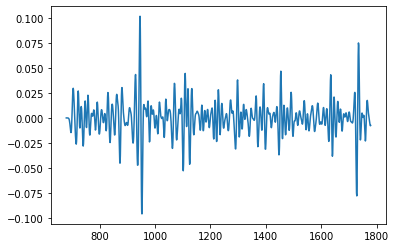

In [ ]:
init = 680
plt.plot(df['(A) INTERCEPT_ORIG_TEMPO'][init:])

./ucr.run sism.txt sint.txt 142 0.1 > saida.txt
614


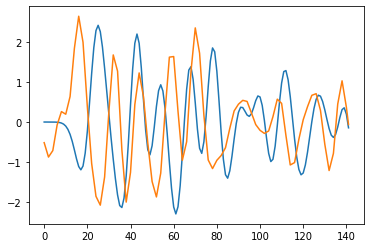

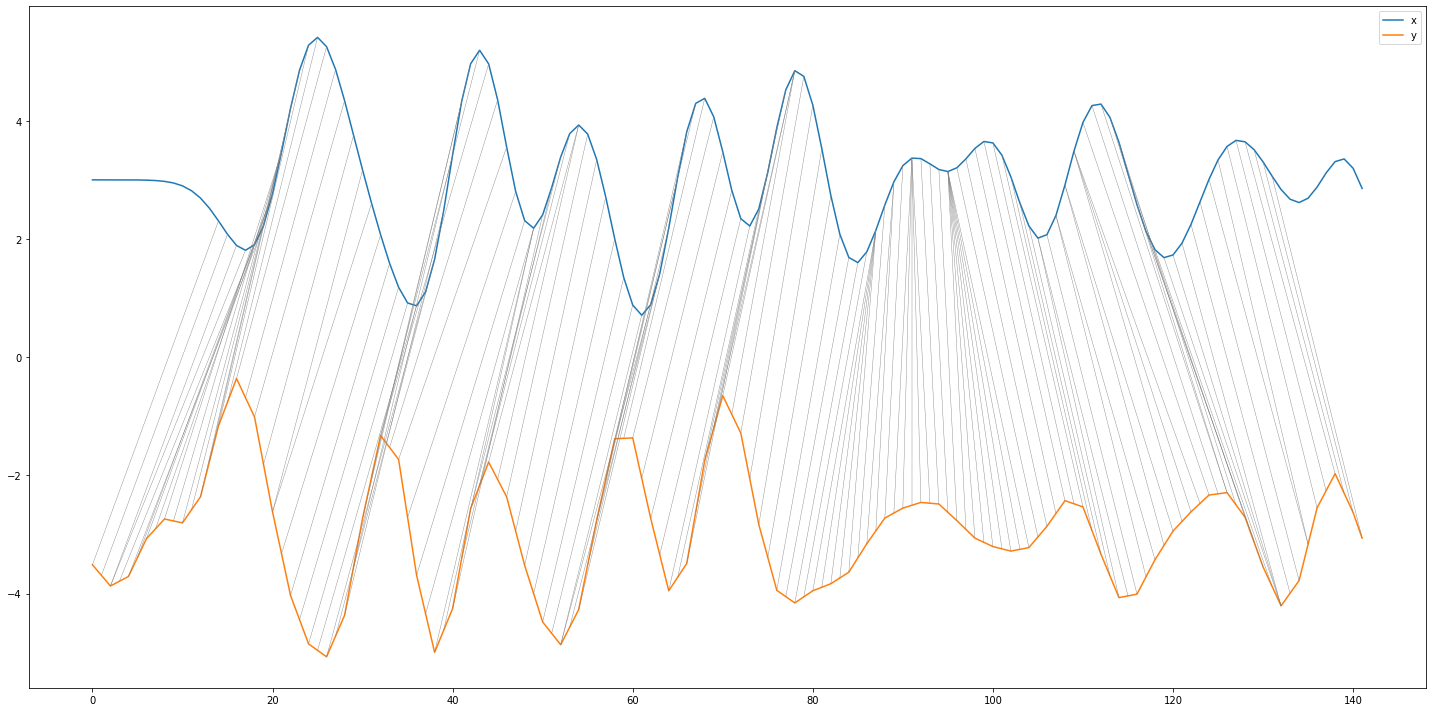

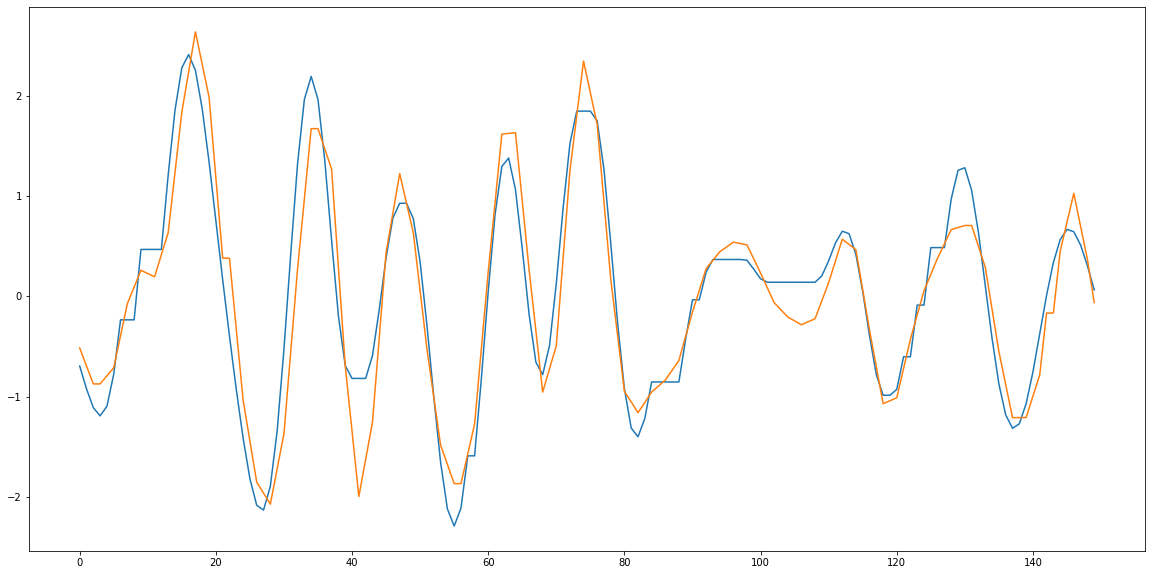

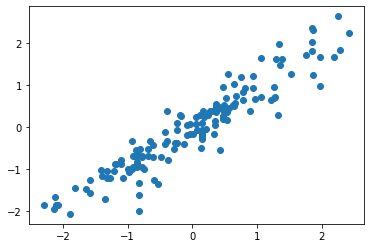

(0.9407987261445993, masked_array(data=2.0195683e-71,
             mask=False,
       fill_value=1e+20))


In [ ]:
getTopo(df['(B) PSTM_COR'], df['(A) INTERCEPT_ORIG_TEMPO'][init:], 8, 0.1)

In [ ]:
#teste TOPO 8%
index = init + int(0.08*size)
size_query = len(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
print("size", size_query)
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][init:index].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print("fim",index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 142 0.1

size 142
fim 822
.
Location : 614
Distance : 3.08291
Data Scanned : 1779
Total Execution Time : 0.033671 sec

Pruned by LB_Keogh  :   7.31%
Pruned by LB_Keogh2 :  38.00%
DTW Calculation     :  54.69%


INTERCEPT vs PSTM


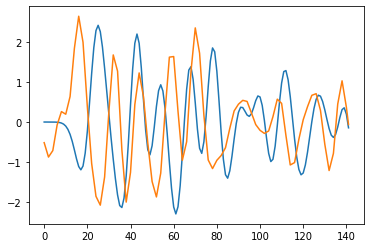

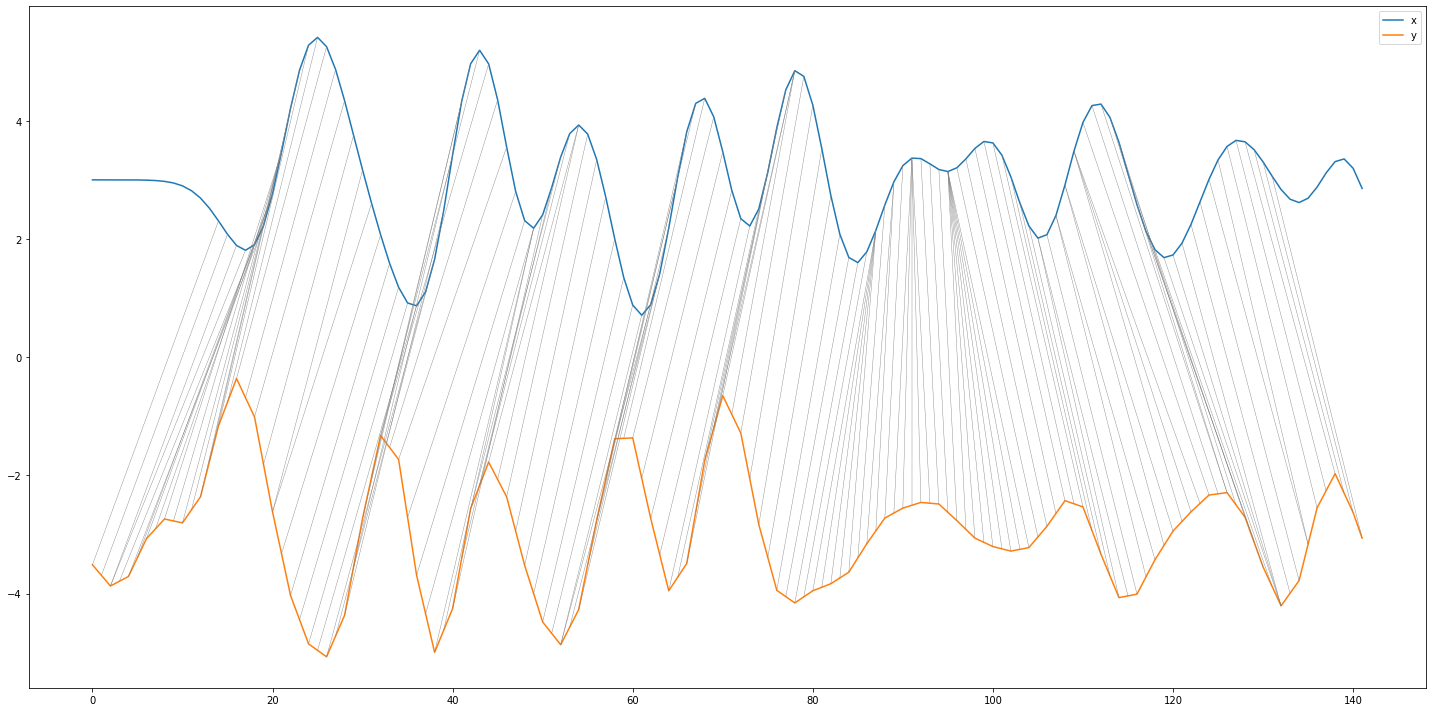

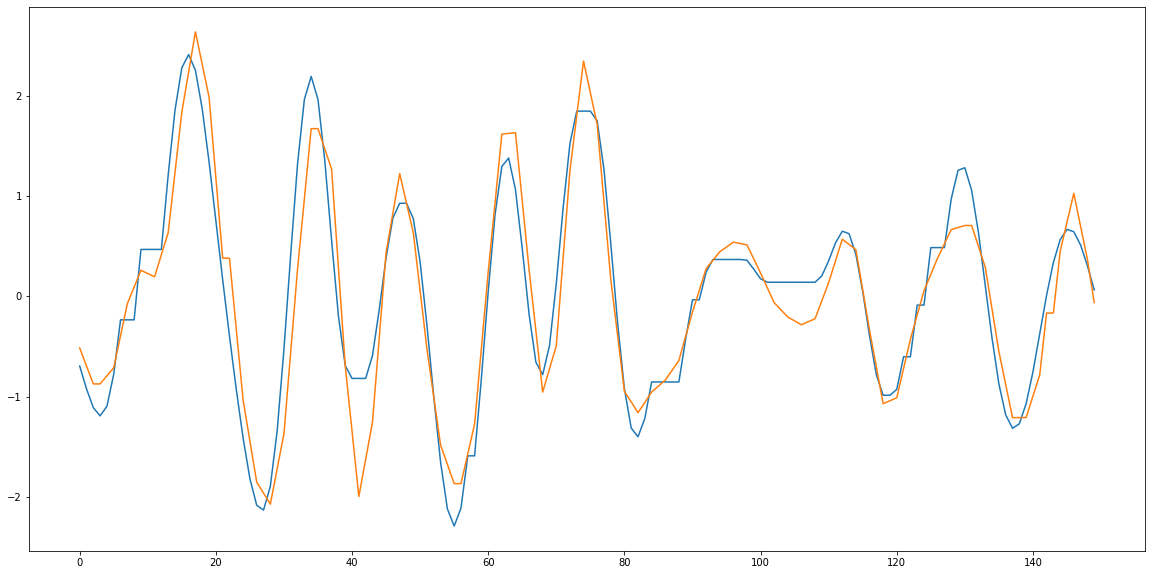

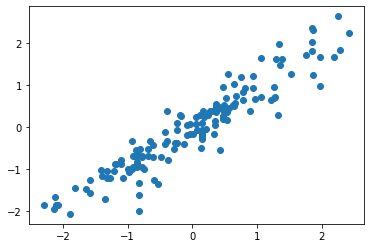

(0.9407987261445993, masked_array(data=2.0195683e-71,
             mask=False,
       fill_value=1e+20))


In [ ]:
print('INTERCEPT vs PSTM')
init_ucr = 614
x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
y = zscore(df['(B) PSTM_COR'][init_ucr:init_ucr+size_query]) 
a,b,pairs = plot_stuff(x,y,w=0.1)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

In [ ]:
#teste TOPO 10%
index = init + int(0.10*size)
size_query = len(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
print("size", size_query)
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][init:index].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print("fim",index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 177 0.1

size 177
fim 857
.
Location : 615
Distance : 3.57048
Data Scanned : 1779
Total Execution Time : 0.059078 sec

Pruned by LB_Keogh  :   3.99%
Pruned by LB_Keogh2 :  19.73%
DTW Calculation     :  76.28%


INTERCEPT vs PSTM


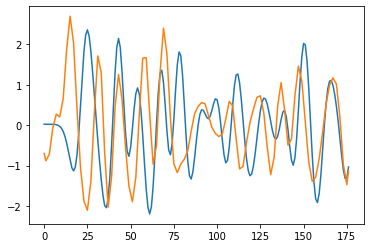

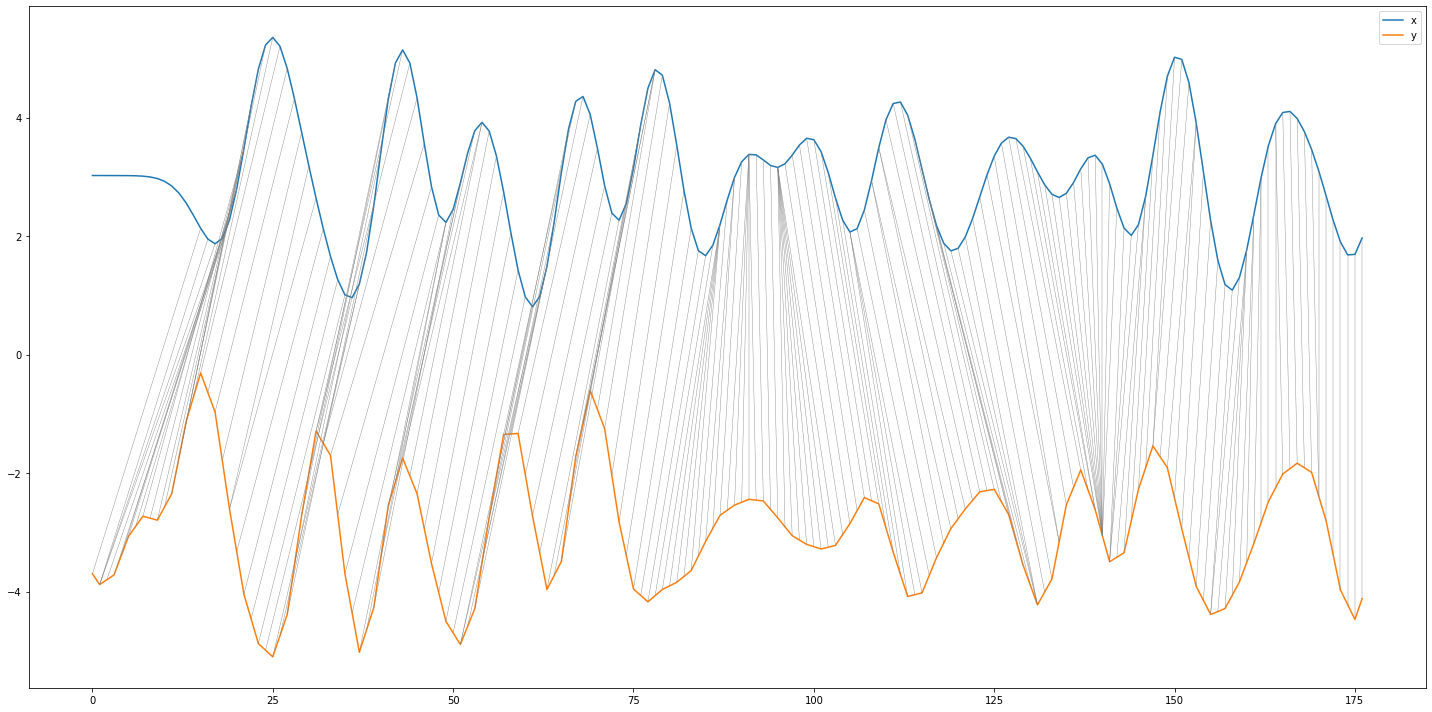

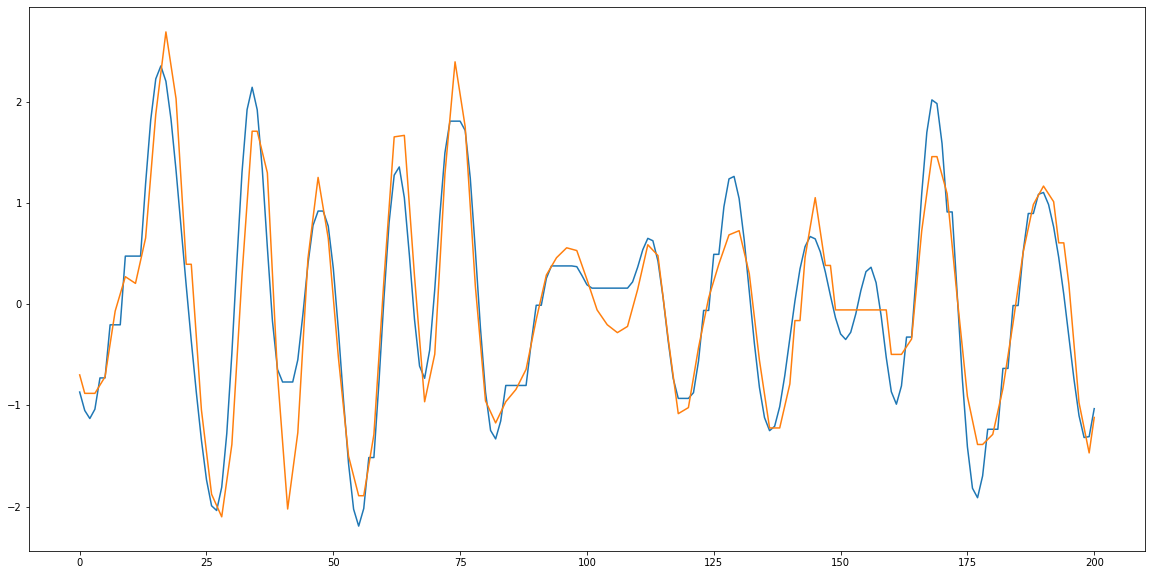

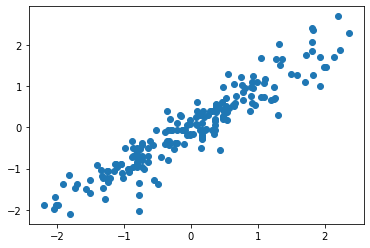

(0.9401040528555683, masked_array(data=5.86331353e-95,
             mask=False,
       fill_value=1e+20))


In [ ]:
print('INTERCEPT vs PSTM')
init_ucr = 615
x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
y = zscore(df['(B) PSTM_COR'][init_ucr:init_ucr+size_query]) 
a,b,pairs = plot_stuff(x,y,w=0.1)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

In [ ]:
#teste TOPO 13%
index = init + int(0.13*size)
size_query = len(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
print("size", size_query)
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][init:index].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print("fim",index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 231 0.1

size 231
fim 911
.
Location : 605
Distance : 5.11162
Data Scanned : 1779
Total Execution Time : 0.147375 sec

Pruned by LB_Keogh  :   0.84%
Pruned by LB_Keogh2 :   4.33%
DTW Calculation     :  94.83%


INTERCEPT vs PSTM


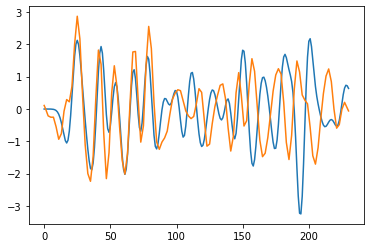

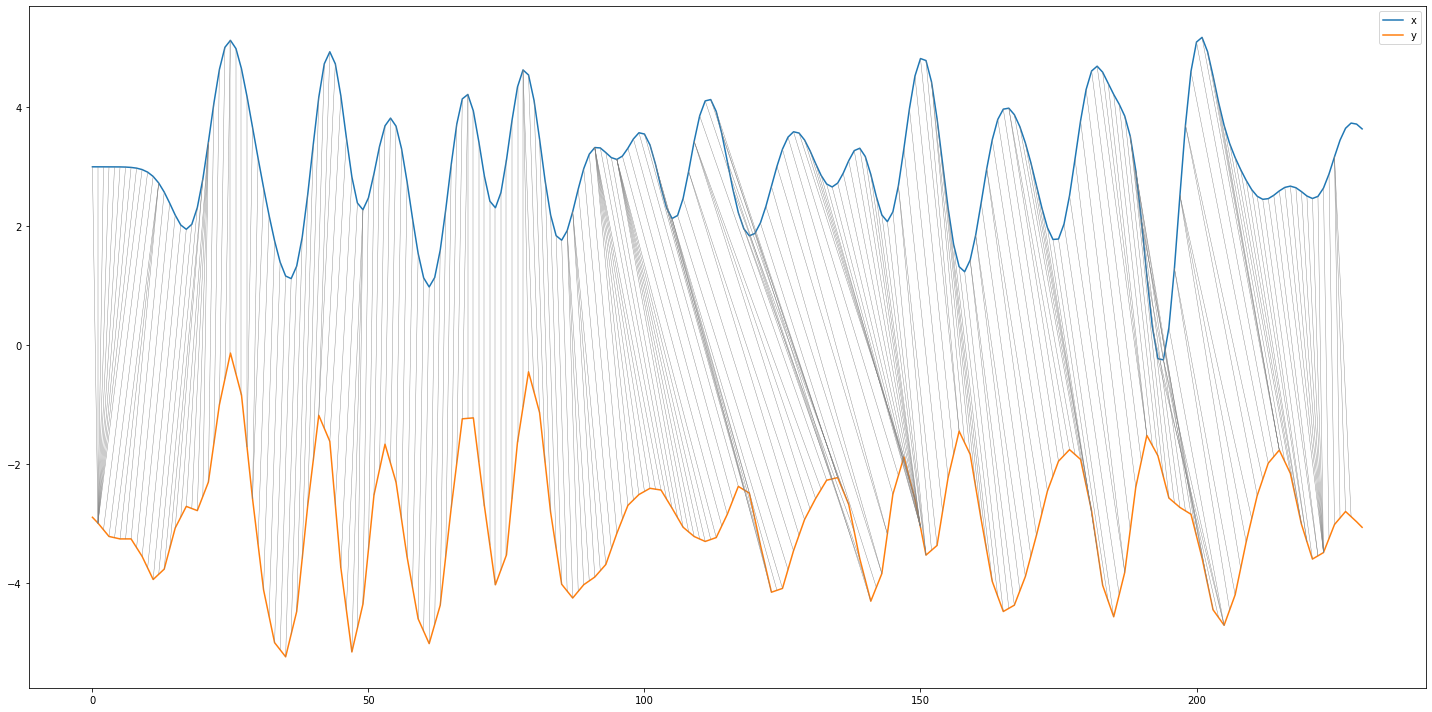

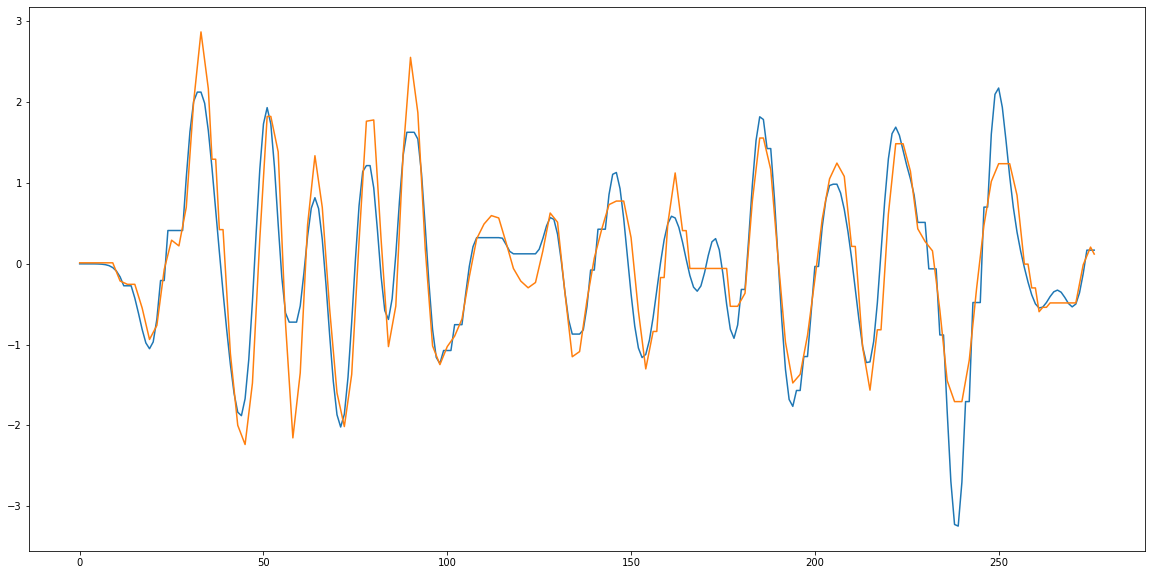

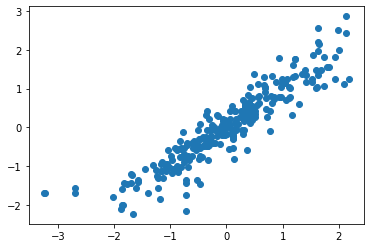

(0.9209312259373144, masked_array(data=1.49945811e-114,
             mask=False,
       fill_value=1e+20))


In [ ]:
print('INTERCEPT vs PSTM')
init_ucr = 605
x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
y = zscore(df['(B) PSTM_COR'][init_ucr:init_ucr+size_query]) 
a,b,pairs = plot_stuff(x,y,w=0.1)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

In [ ]:
#teste TOPO 15%
index = init + int(0.15*size)
size_query = len(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
print("size", size_query)
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][init:index].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print("fim",index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 266 0.1

size 266
fim 946
.
Location : 617
Distance : 4.93794
Data Scanned : 1779
Total Execution Time : 0.187495 sec

Pruned by LB_Keogh  :   9.11%
Pruned by LB_Keogh2 :   0.00%
DTW Calculation     :  90.89%


INTERCEPT vs PSTM


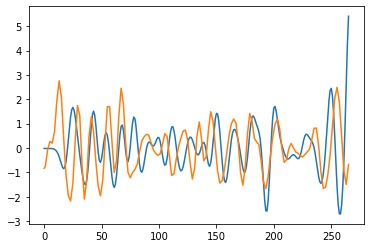

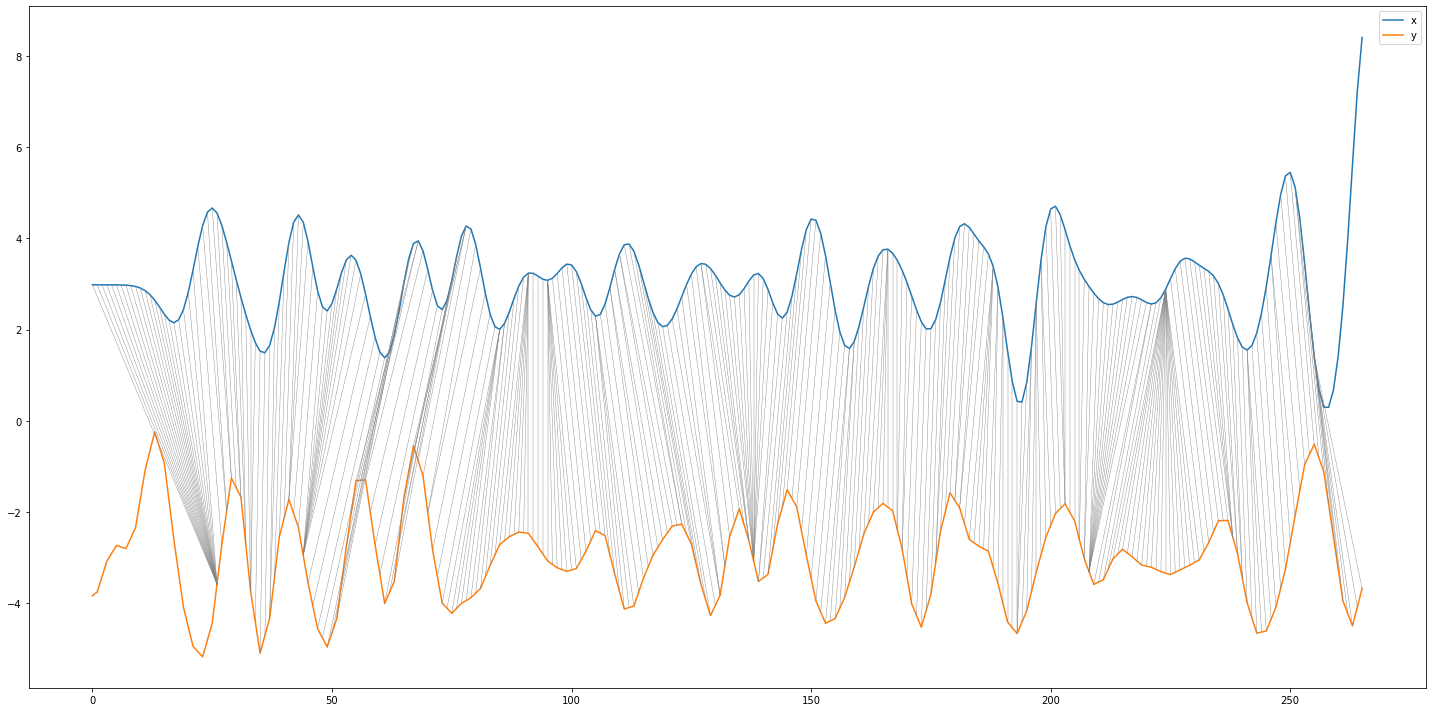

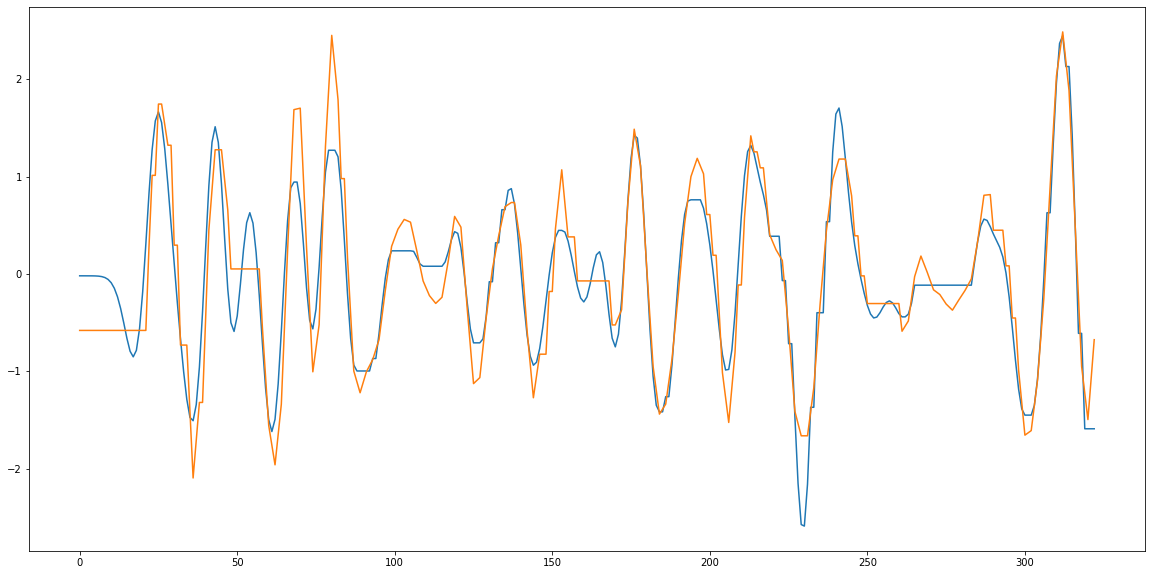

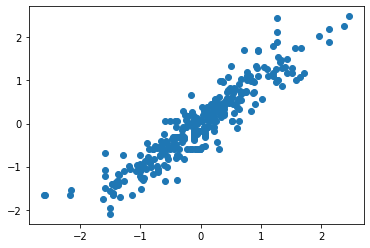

(0.9260686763153997, masked_array(data=6.58071871e-138,
             mask=False,
       fill_value=1e+20))


In [ ]:
print('INTERCEPT vs PSTM')
init_ucr = 617
x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
y = zscore(df['(B) PSTM_COR'][init_ucr:init_ucr+size_query]) 
a,b,pairs = plot_stuff(x,y,w=0.1)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

In [ ]:
#teste TOPO 20%
index = init + int(0.20*size)
size_query = len(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
print("size", size_query)
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][init:index].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print("fim",index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 355 0.1

size 355
fim 1035
.
Location : 640
Distance : 6.89202
Data Scanned : 1779
Total Execution Time : 0.164948 sec

Pruned by LB_Keogh  :   3.65%
Pruned by LB_Keogh2 :  30.80%
DTW Calculation     :  65.54%


INTERCEPT vs PSTM


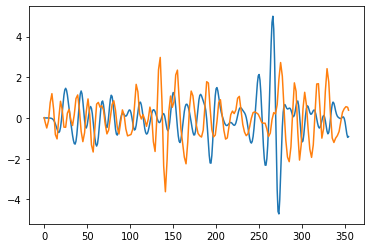

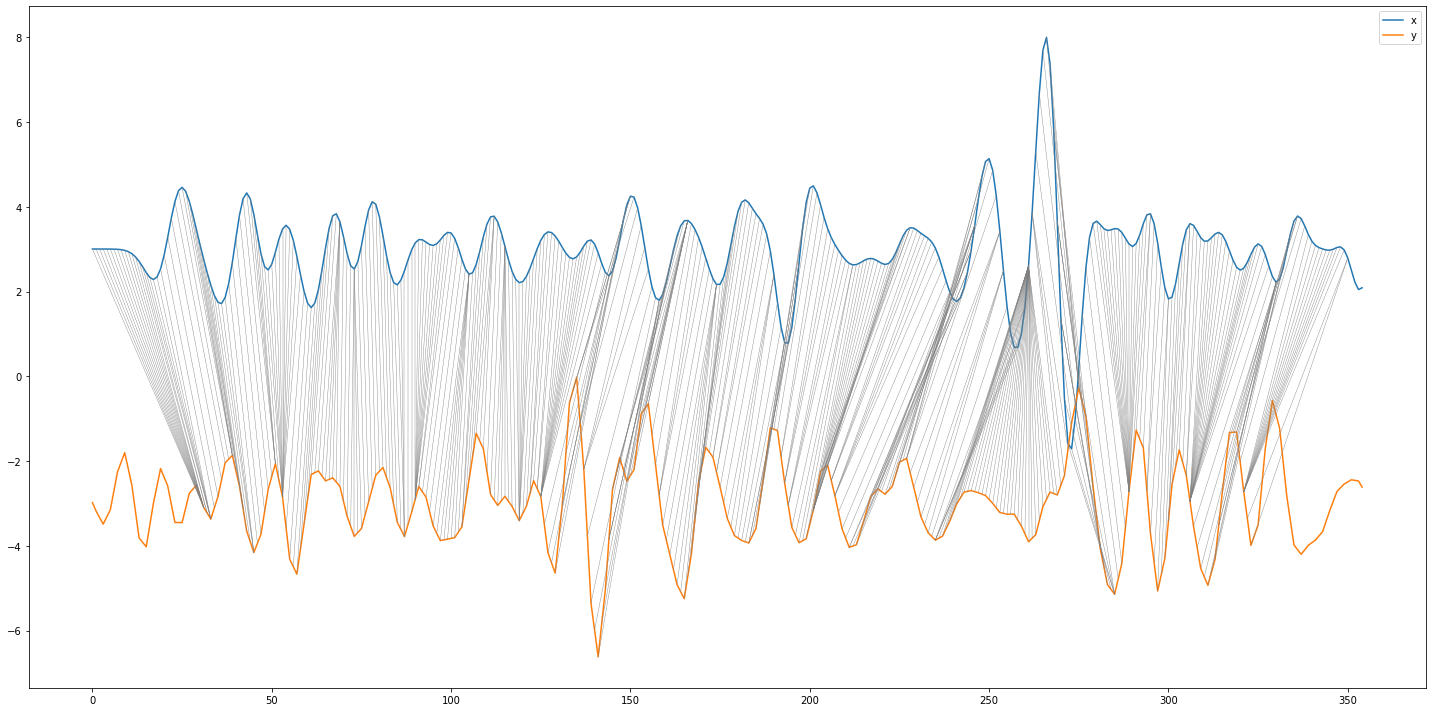

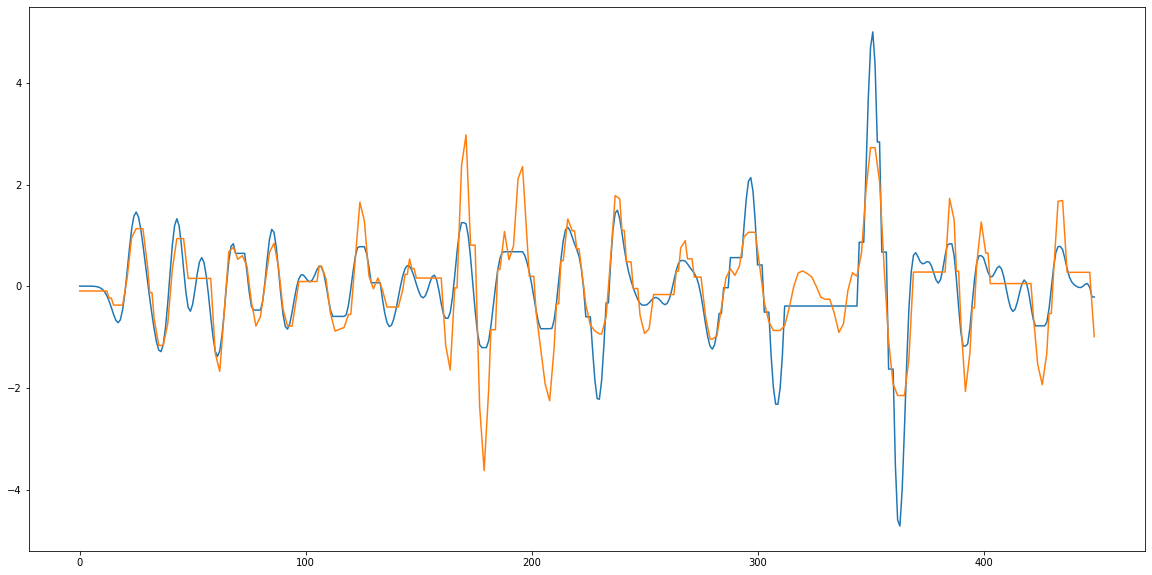

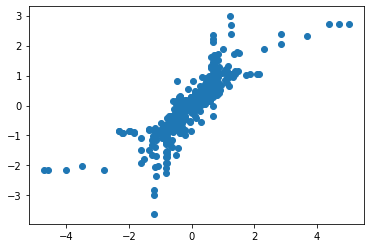

(0.8272096078375937, masked_array(data=3.18406639e-114,
             mask=False,
       fill_value=1e+20))


In [ ]:
print('INTERCEPT vs PSTM')
init_ucr = 355
x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
y = zscore(df['(B) PSTM_COR'][init_ucr:init_ucr+size_query]) 
a,b,pairs = plot_stuff(x,y,w=0.1)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

In [ ]:
#teste TOPO 25%
index = init + int(0.25*size)
size_query = len(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
print("size", size_query)
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][init:index].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print("fim",index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 444 0.1

size 444
fim 1124
.
Location : 636
Distance : 7.3214
Data Scanned : 1779
Total Execution Time : 0.325064 sec

Pruned by LB_Keogh  :   2.81%
Pruned by LB_Keogh2 :  24.11%
DTW Calculation     :  73.07%


INTERCEPT vs PSTM


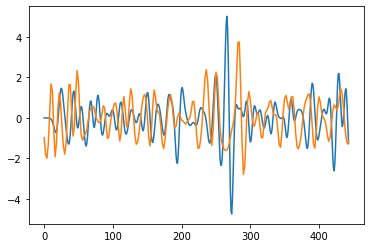

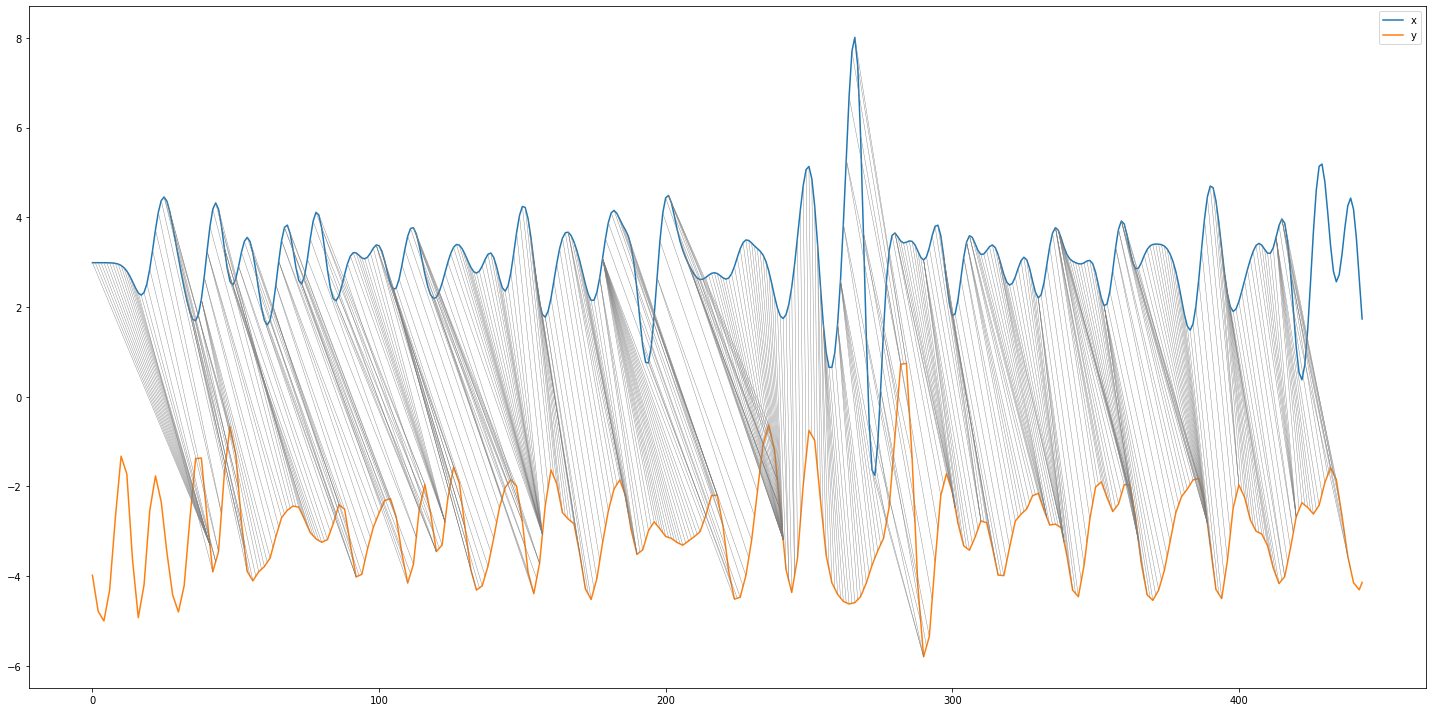

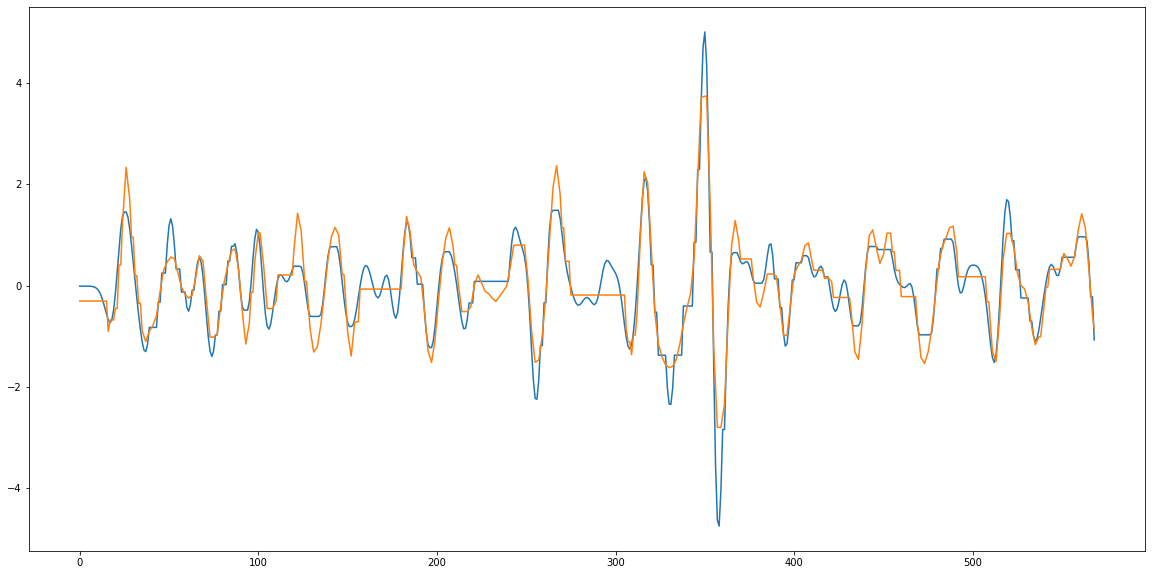

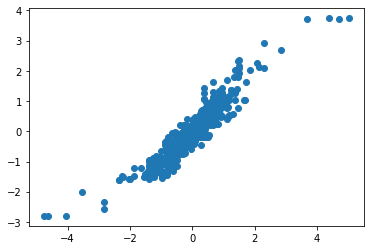

(0.9303106341274656, masked_array(data=3.70876214e-249,
             mask=False,
       fill_value=1e+20))


In [ ]:
print('INTERCEPT vs PSTM')
init_ucr = 636
x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
y = zscore(df['(B) PSTM_COR'][init_ucr:init_ucr+size_query]) 
a,b,pairs = plot_stuff(x,y,w=0.1)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

**procurando TOPO, DTW Psi com janela 15**

In [ ]:
#teste TOPO 10%
index = init + int(0.10*size)
size_query = len(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
print("size", size_query)
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][init:index].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print("fim",index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 177 0.15

NameError: ignored

INTERCEPT vs PSTM


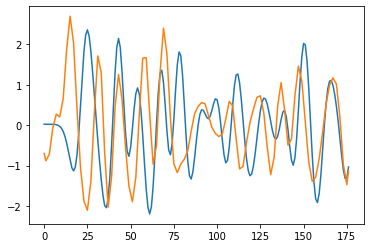

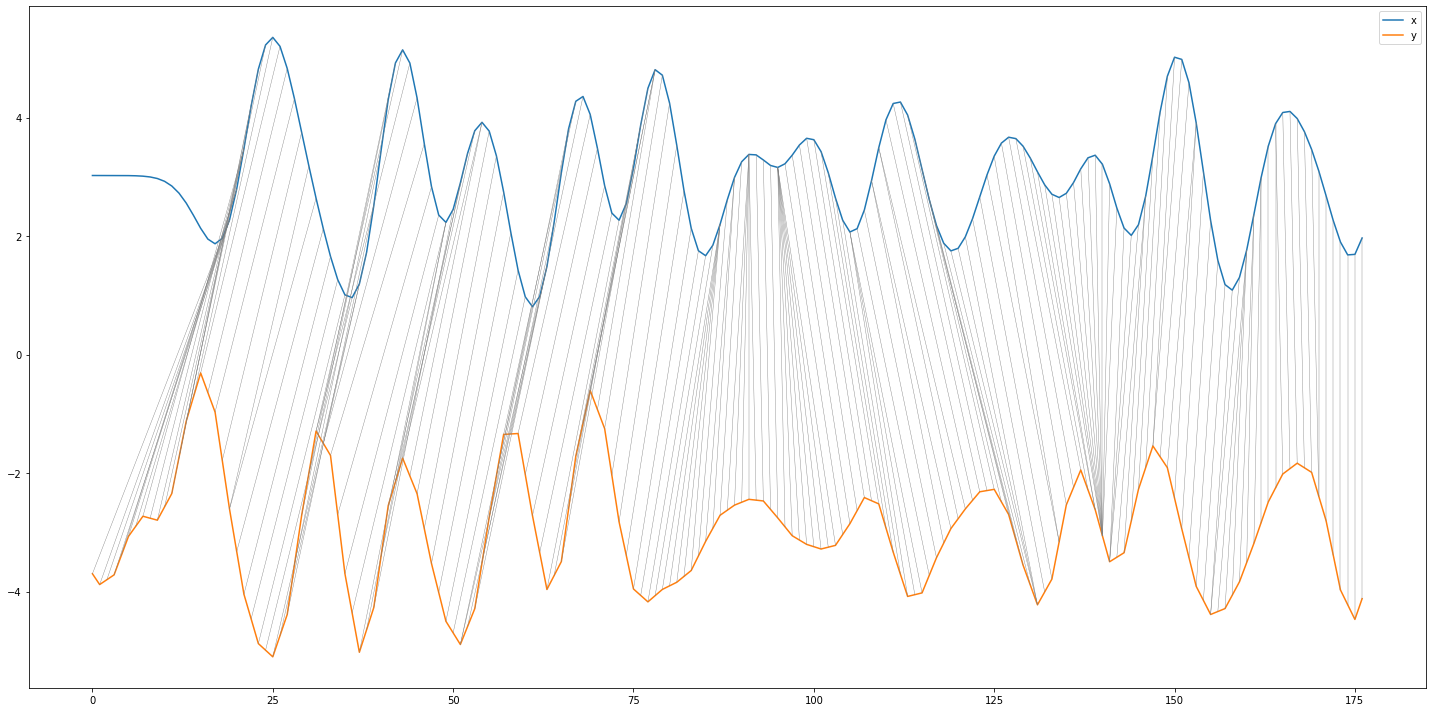

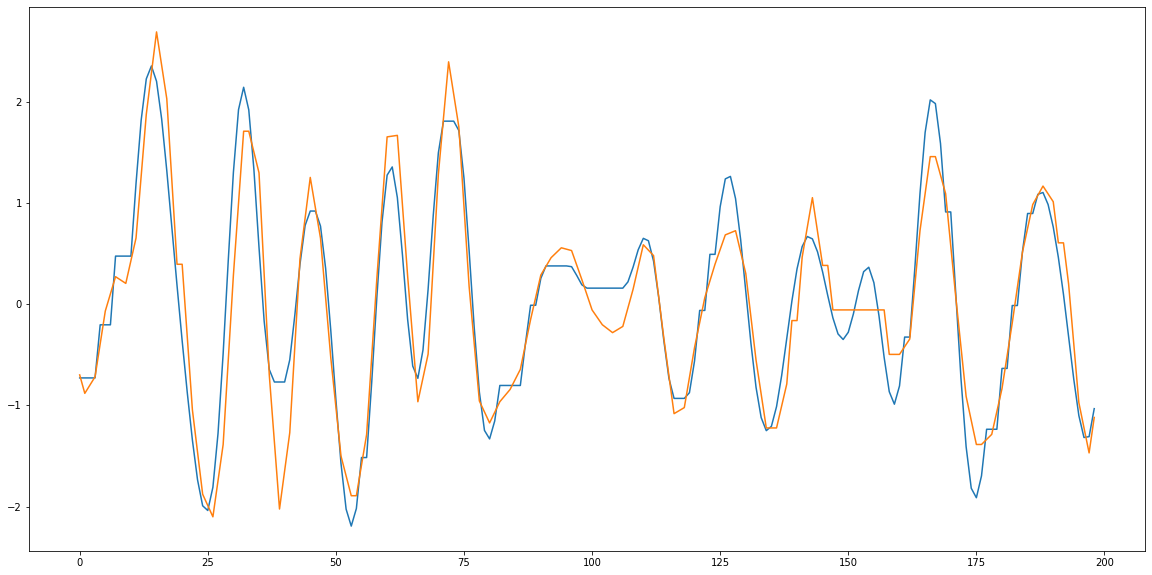

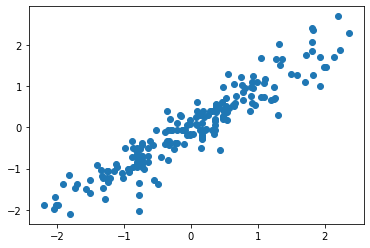

(0.9397498533238161, masked_array(data=8.90600799e-94,
             mask=False,
       fill_value=1e+20))


In [ ]:
print('INTERCEPT vs PSTM')
init_ucr = 615
x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
y = zscore(df['(B) PSTM_COR'][init_ucr:init_ucr+size_query]) 
a,b,pairs = plot_stuff(x,y,w=0.15)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

In [ ]:
#teste TOPO 15%
index = init + int(0.15*size)
size_query = len(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
print("size", size_query)
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][init:index].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print("fim",index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 266 0.1

size 266
fim 946
.
Location : 617
Distance : 4.93794
Data Scanned : 1779
Total Execution Time : 0.192588 sec

Pruned by LB_Keogh  :   9.11%
Pruned by LB_Keogh2 :   0.00%
DTW Calculation     :  90.89%


INTERCEPT vs PSTM


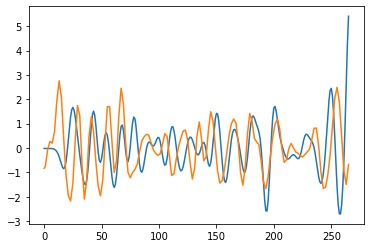

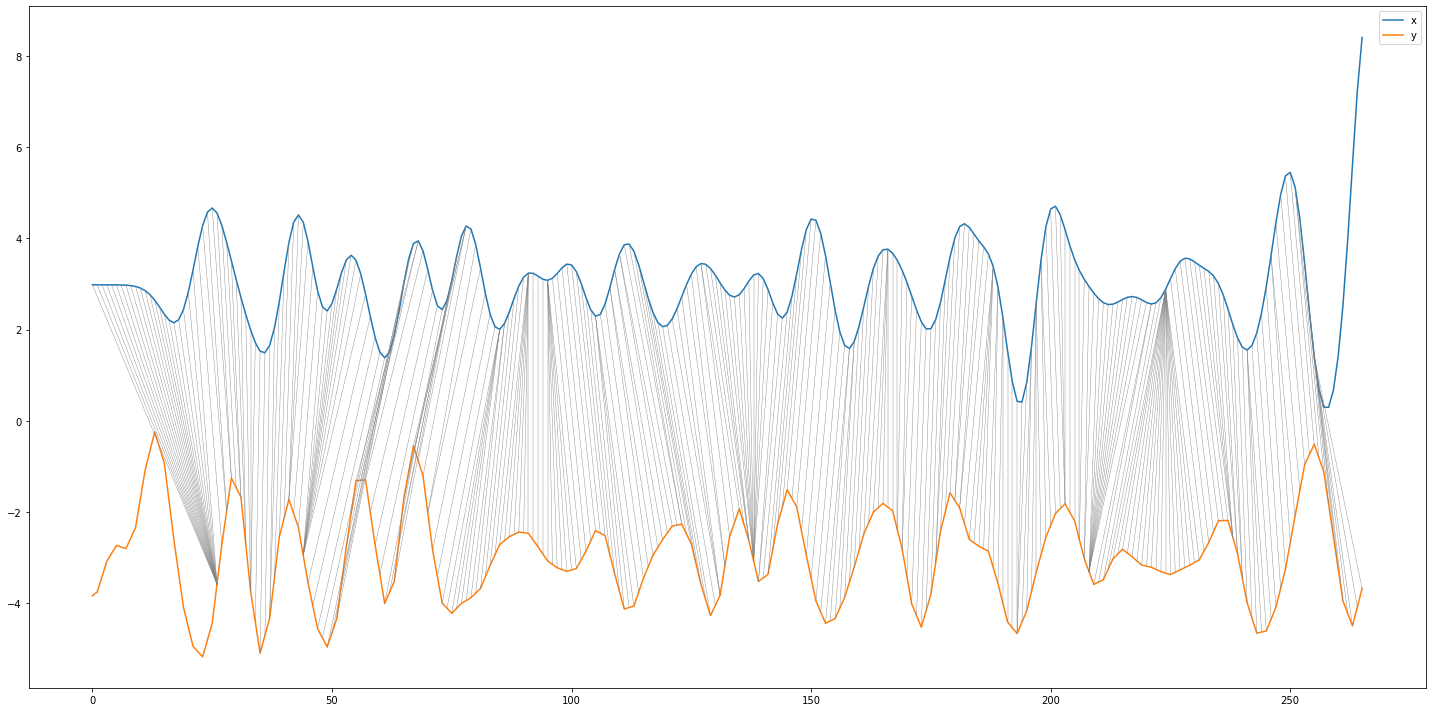

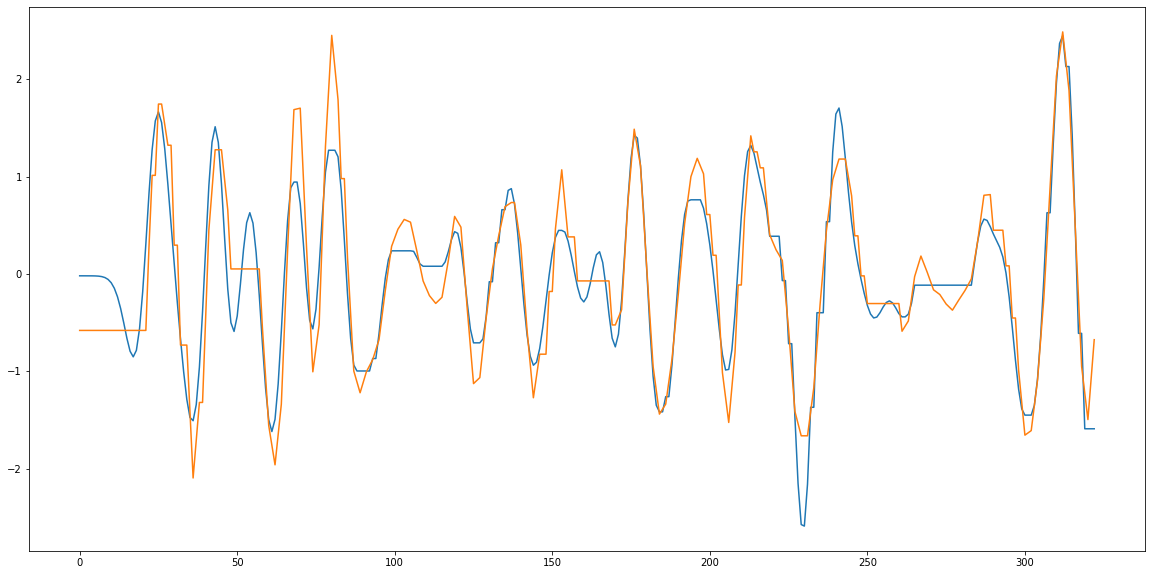

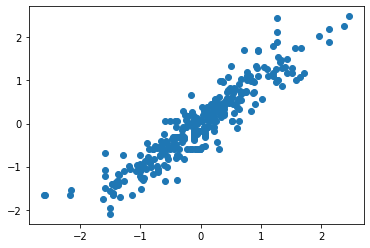

(0.9260686763153997, masked_array(data=6.58071871e-138,
             mask=False,
       fill_value=1e+20))


In [ ]:
print('INTERCEPT vs PSTM')
init_ucr = 617
x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
y = zscore(df['(B) PSTM_COR'][init_ucr:init_ucr+size_query]) 
a,b,pairs = plot_stuff(x,y,w=0.15)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

In [ ]:
#teste TOPO 20%
index = init + int(0.20*size)
size_query = len(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
print("size", size_query)
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][init:index].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print("fim",index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 355 0.1

size 355
fim 1035
.
Location : 640
Distance : 6.89202
Data Scanned : 1779
Total Execution Time : 0.170251 sec

Pruned by LB_Keogh  :   3.65%
Pruned by LB_Keogh2 :  30.80%
DTW Calculation     :  65.54%


INTERCEPT vs PSTM


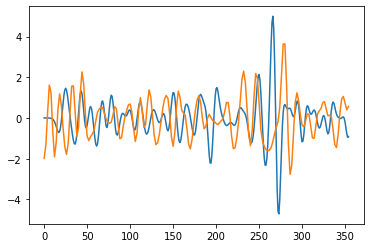

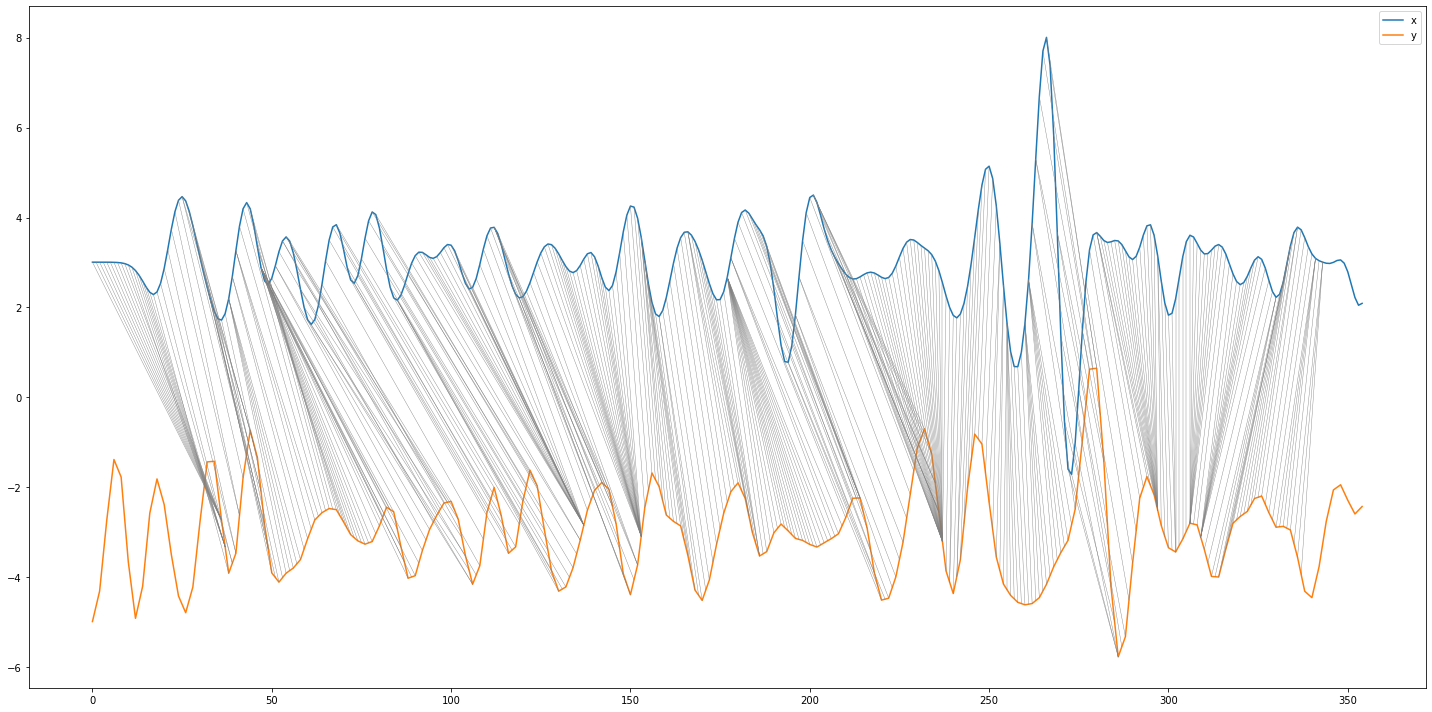

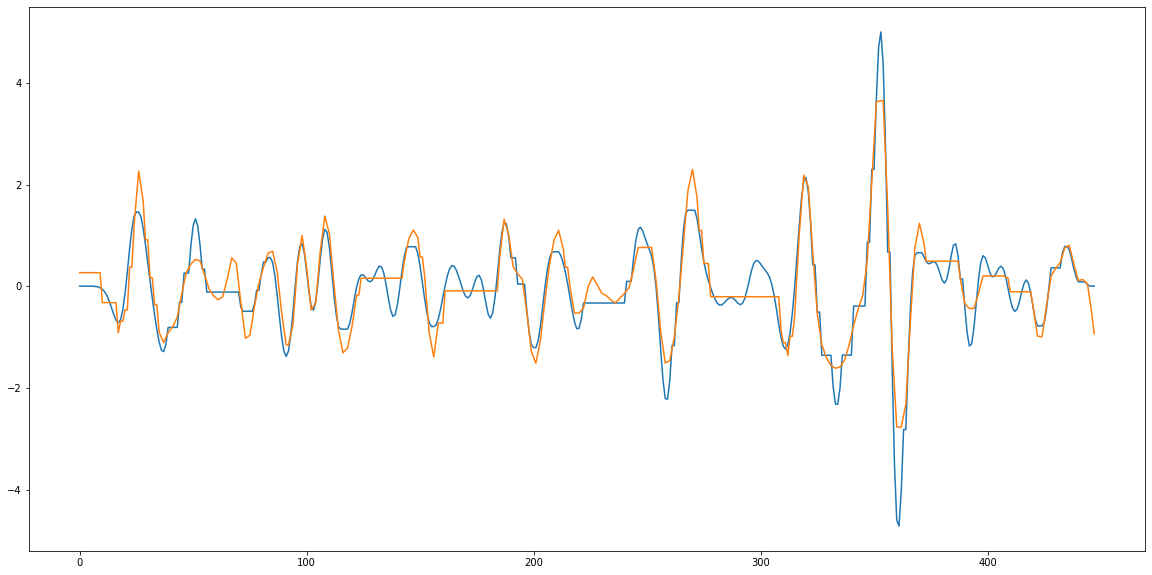

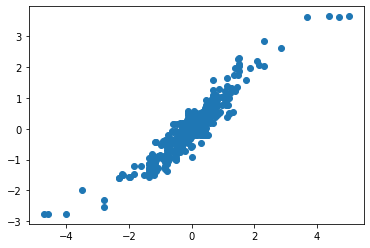

(0.9317780132457464, masked_array(data=2.19362501e-198,
             mask=False,
       fill_value=1e+20))


In [ ]:
print('INTERCEPT vs PSTM')
init_ucr = 640
x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
y = zscore(df['(B) PSTM_COR'][init_ucr:init_ucr+size_query]) 
a,b,pairs = plot_stuff(x,y,w=0.15)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

**Procurando TOPO com w = 2**

In [ ]:
#teste TOPO 10%
index = init + int(0.1*size)
size_query = len(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
print("size", size_query)
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][init:index].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print("fim",index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 177 0.1

size 177
fim 857
.
Location : 615
Distance : 3.57048
Data Scanned : 1779
Total Execution Time : 0.059935 sec

Pruned by LB_Keogh  :   3.99%
Pruned by LB_Keogh2 :  19.73%
DTW Calculation     :  76.28%


INTERCEPT vs PSTM


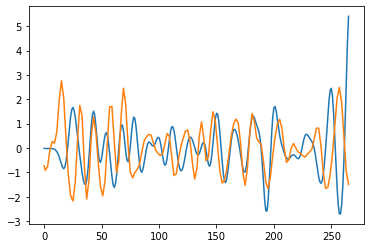

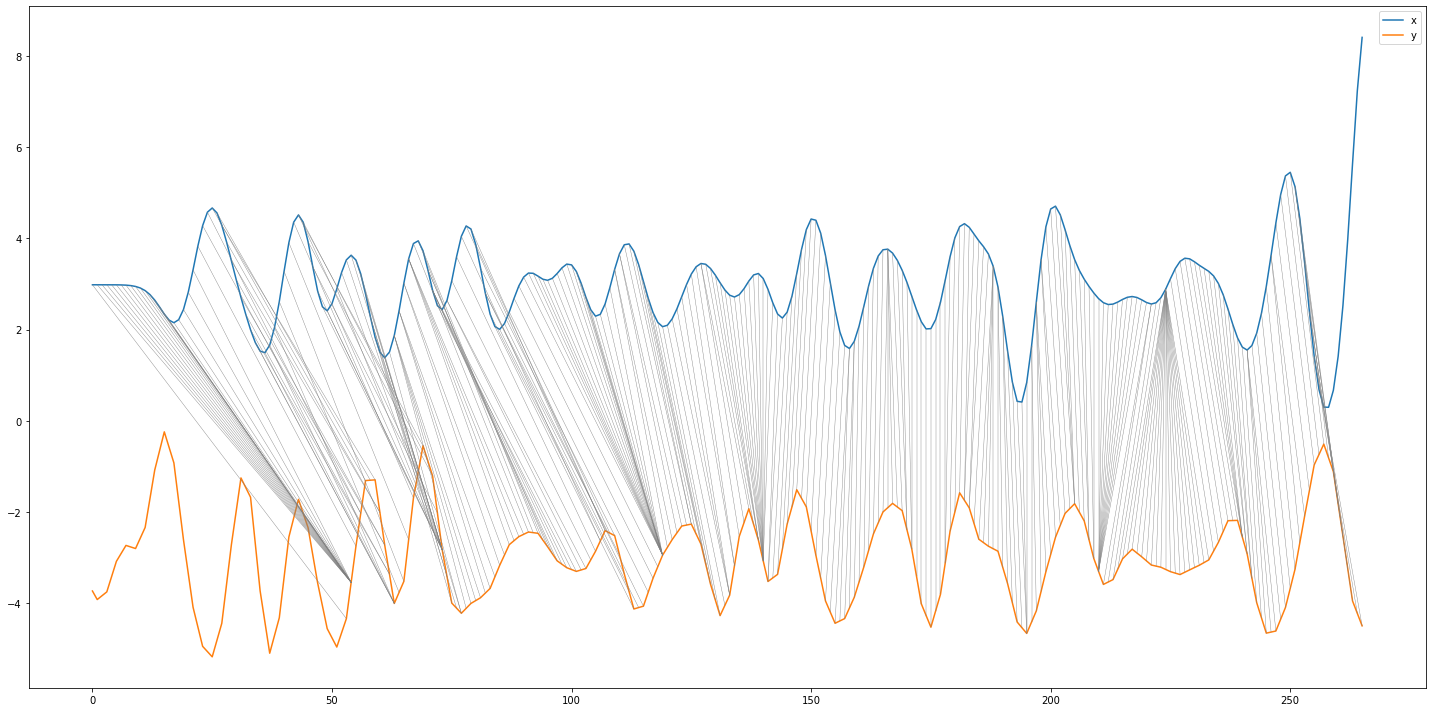

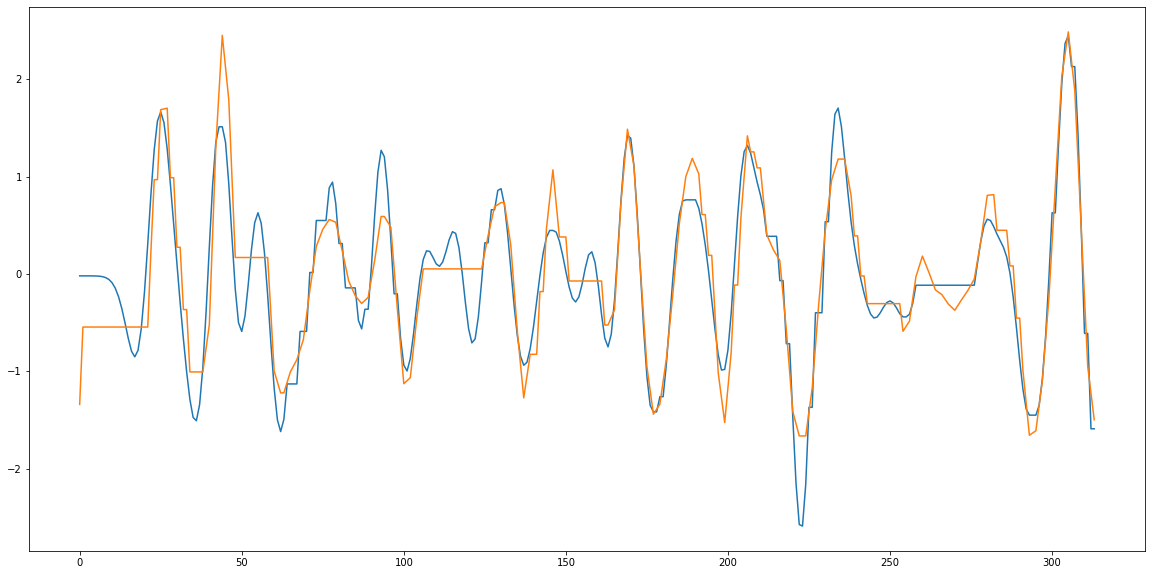

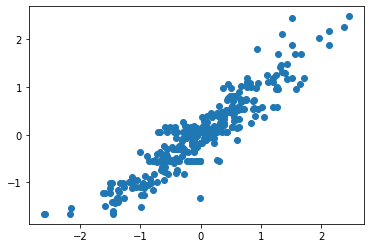

(0.9251005550020275, masked_array(data=3.0303169e-133,
             mask=False,
       fill_value=1e+20))


In [ ]:
print('INTERCEPT vs PSTM')
init_ucr = 615
x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
y = zscore(df['(B) PSTM_COR'][init_ucr:init_ucr+size_query]) 
a,b,pairs = plot_stuff(x,y,w=0.2)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

In [ ]:
#teste TOPO 15%
index = init + int(0.15*size)
size_query = len(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
print("size", size_query)
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][init:index].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print("fim",index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 266 0.1

size 266
fim 946
.
Location : 617
Distance : 4.93794
Data Scanned : 1779
Total Execution Time : 0.193505 sec

Pruned by LB_Keogh  :   9.11%
Pruned by LB_Keogh2 :   0.00%
DTW Calculation     :  90.89%


INTERCEPT vs PSTM


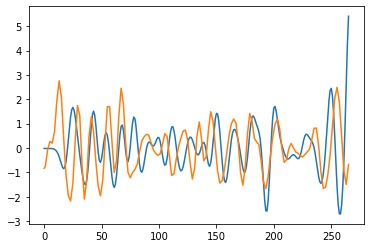

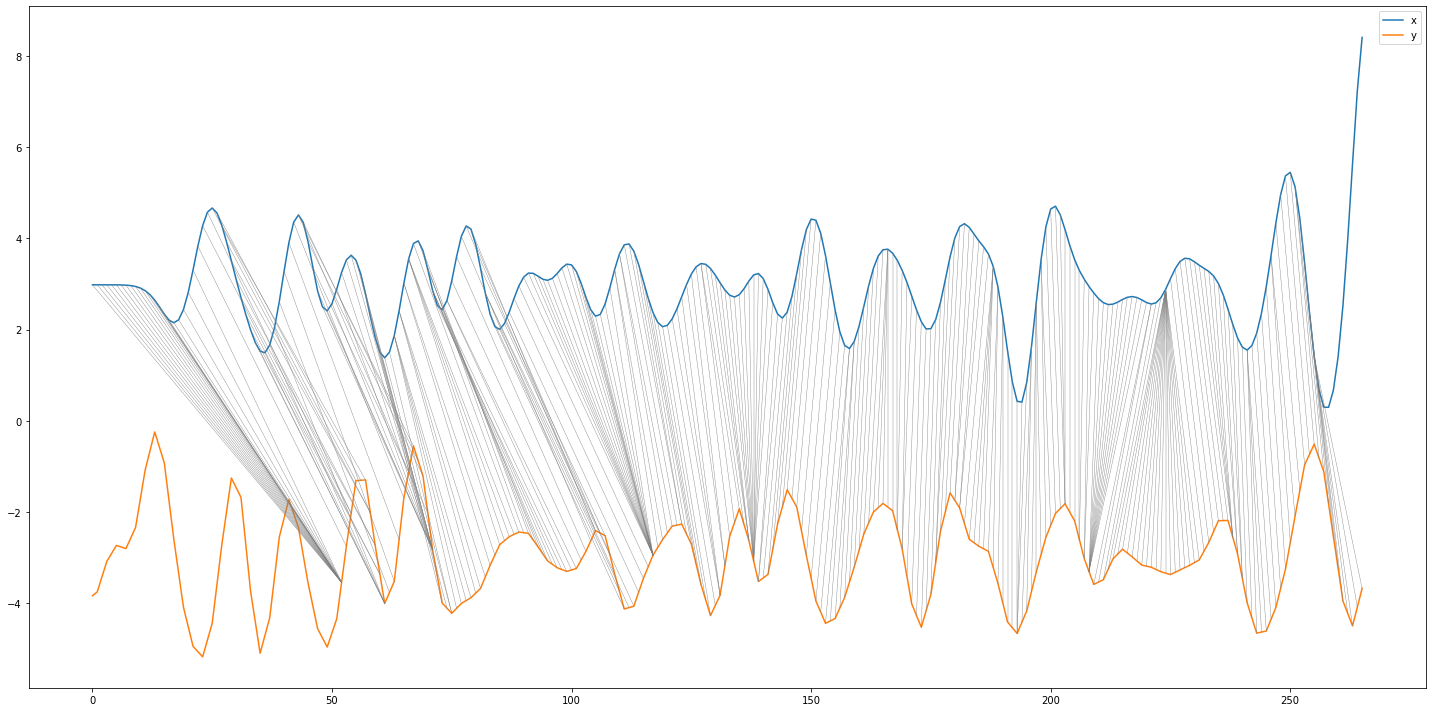

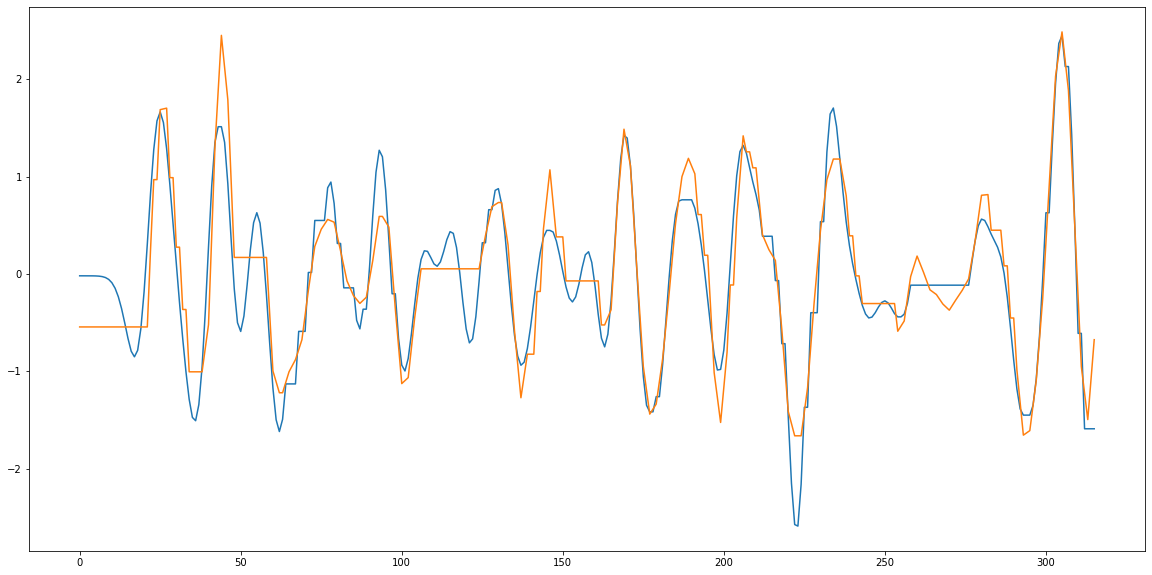

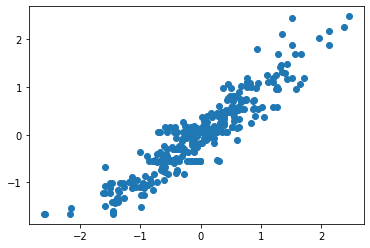

(0.92730028523615, masked_array(data=4.82362956e-136,
             mask=False,
       fill_value=1e+20))


In [ ]:
print('INTERCEPT vs PSTM')
init_ucr = 617
x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
y = zscore(df['(B) PSTM_COR'][init_ucr:init_ucr+size_query]) 
a,b,pairs = plot_stuff(x,y,w=0.2)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))

In [ ]:
#teste TOPO 20%
index = init + int(0.2*size)
size_query = len(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
print("size", size_query)
np.savetxt('sint_10.txt', df['(A) INTERCEPT_ORIG_TEMPO'][init:index].to_numpy())
np.savetxt('sism.txt', df['(B) PSTM_COR'].to_numpy())
print("fim",index)
#!./ucr.run sism.txt sint.txt 1779 0.1
!./ucr.run sism.txt sint_10.txt 355 0.1

size 355
fim 1035
.
Location : 640
Distance : 6.89202
Data Scanned : 1779
Total Execution Time : 0.172971 sec

Pruned by LB_Keogh  :   3.65%
Pruned by LB_Keogh2 :  30.80%
DTW Calculation     :  65.54%


INTERCEPT vs PSTM


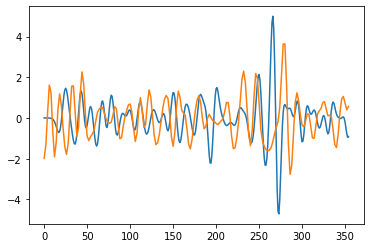

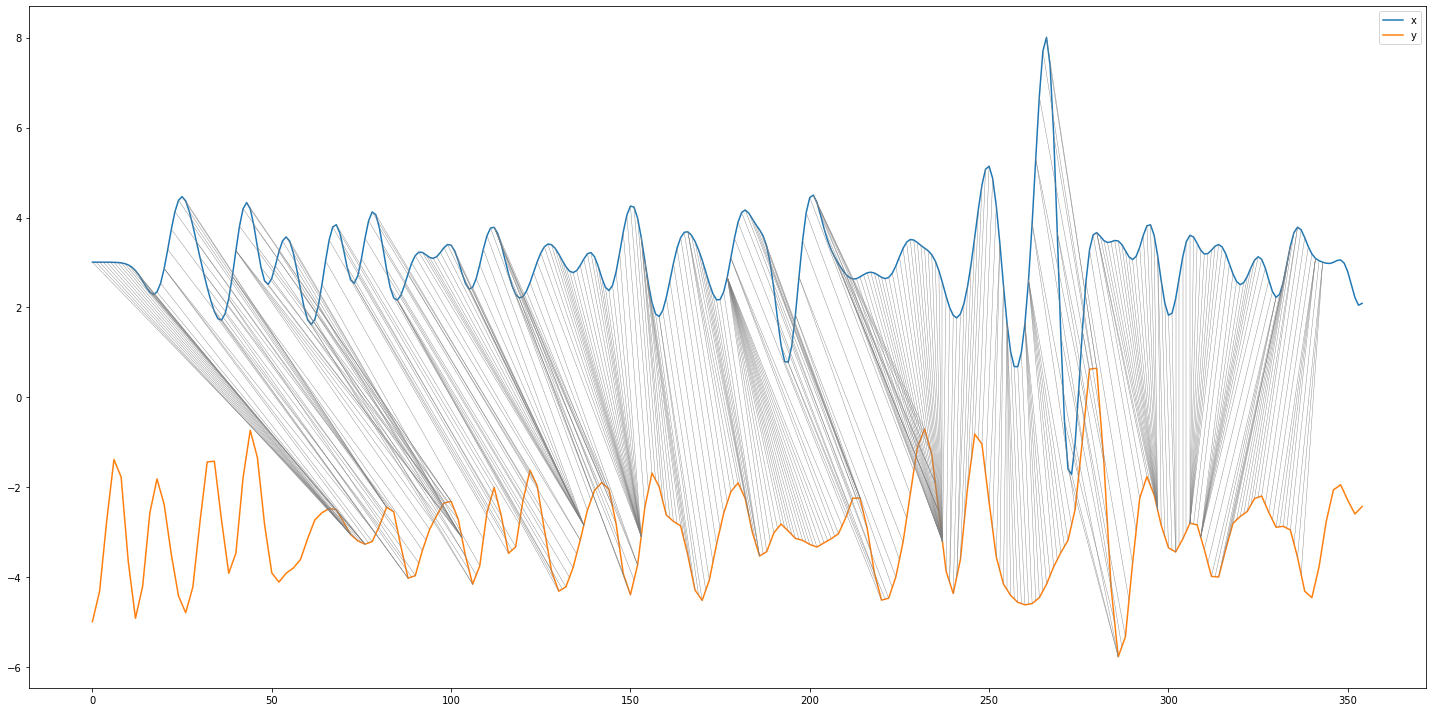

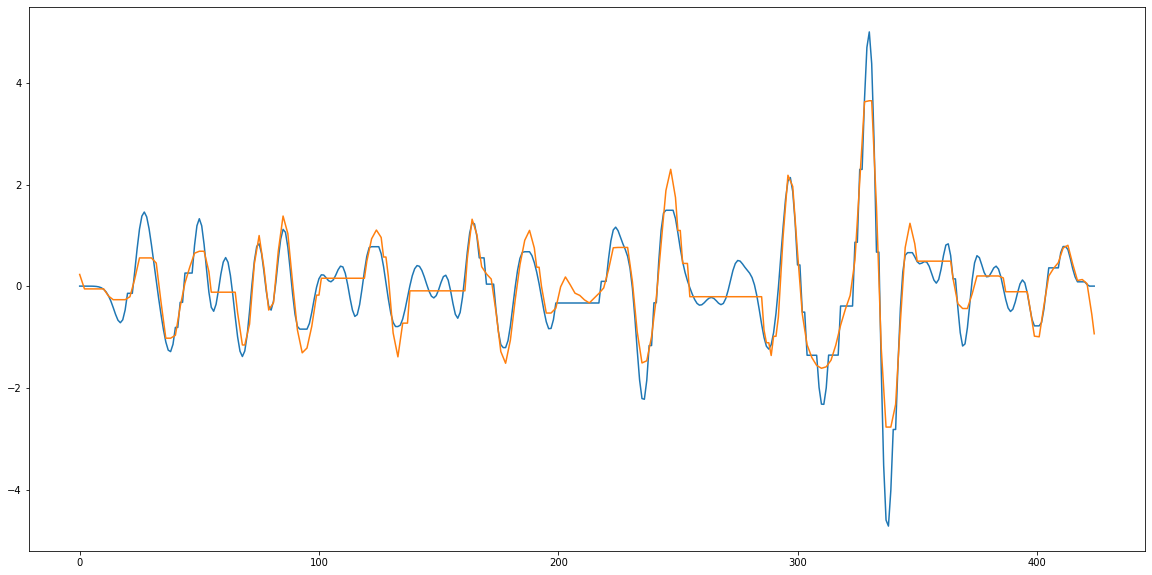

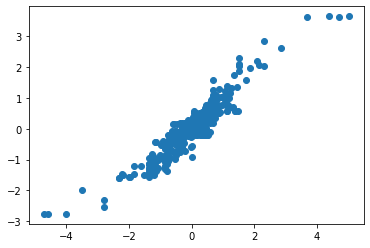

(0.9345259414569925, masked_array(data=6.71338799e-192,
             mask=False,
       fill_value=1e+20))


In [ ]:
print('INTERCEPT vs PSTM')
init_ucr = 640
x = zscore(df['(A) INTERCEPT_ORIG_TEMPO'][init:index])
y = zscore(df['(B) PSTM_COR'][init_ucr:init_ucr+size_query]) 
a,b,pairs = plot_stuff(x,y,w=0.2)
plt.scatter(a,b)
plt.show()

print(pearsonr(a,b))